# Duration Prediction

In [1]:
from html.parser import piclose

import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
def preprocessing(df):
    # compute target variables: trip duration in minutes
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    # keep only trips of less than an hour
    df = df.loc[(df.duration >= 1) & (df.duration <= 60), :]

    return df

In [3]:
def one_hot_encoding(df, numerical, categorical, dv=None):
    df[categorical] = df[categorical].astype(str)
    df_dicts = df[categorical + numerical].to_dict(orient='records')

    if not dv:
        dv = DictVectorizer()
        dv.fit(df_dicts)

    X_train = dv.transform(df_dicts)

    return X_train, dv

In [4]:
# read im the raw data
df_train = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [5]:
# data cleaning
df_train = preprocessing(df_train)
df_val = preprocessing(df_val)

In [6]:
df_train['PU_DO'] = df_train['PULocationID'].astype(str) + '_' + df_train['DOLocationID'].astype(str)
df_val['PU_DO'] = df_val['PULocationID'].astype(str) + '_' + df_val['DOLocationID'].astype(str)

In [7]:
categorical = ['PULocationID', 'DOLocationID', 'PU_DO']
numerical = ['trip_distance']

In [8]:
# categorical feature encoding
X_train, dv = one_hot_encoding(df_train, numerical, categorical)
X_val, _ = one_hot_encoding(df_val, numerical, categorical, dv=dv)

In [9]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred = lr.predict(X_val)

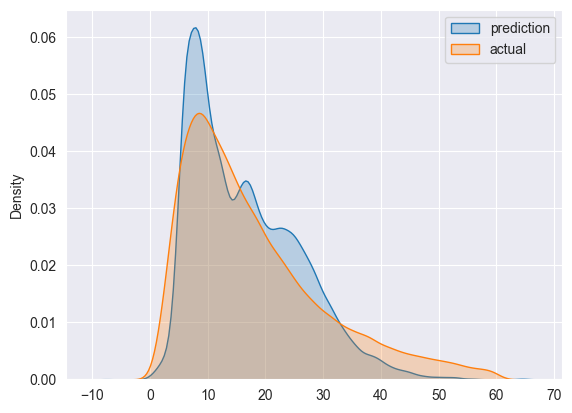

In [12]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)
plt.legend()
plt.show()

In [13]:
root_mean_squared_error(y_val, y_pred)

7.724793692672888

In [14]:
lasso = Lasso(alpha=.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_val)

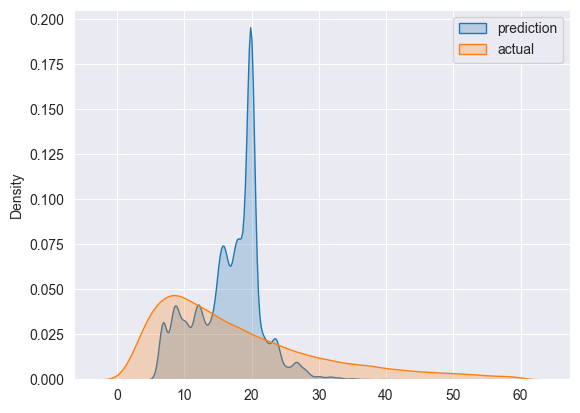

In [15]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)
plt.legend()
plt.show()

In [16]:
root_mean_squared_error(y_val, y_pred)

10.606140572165677

In [17]:
ridge = Ridge(alpha=.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_val)

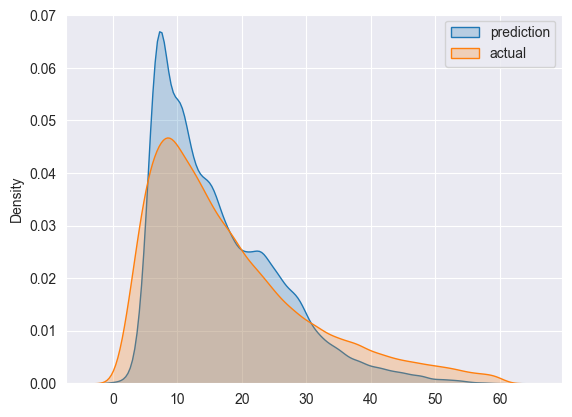

In [18]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)
plt.legend()
plt.show()

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)